### This is the study project as a part of Datacamp's Time series Analysis  course 

# Forecasting Energy Demand With Keras
This notebook implements a simple univariate LSTM model with Kearas structured as a multiple-input, multiple-outputs configuration such that each input and output is the univariate sequence of a given hour of the day.

The model presented here was implemented as part of a project that explored different models to make 24 hour load predictions. The full project can be found in [this github repo](https://github.com/ksopan/Fun_Projects/blob/main/Electricity_Consumption_demand_prediction.ipynb).

## Model Descrption
The model makes a prediction each 24 hours at midnight and forecasts the next 24 hours of demand. Traditional sequence predictions take in hourly consumption in sequnces corresponding to each day's 24 hours followed by the next until the end of the sequence. The method described in this notebook treats each hour of the day as independent. Therefore it considers 24 indivdual forecasts corresponding to each hour of the day. The benefit of this method is that 1) we take advantage of stronger direct (partial) autocorrelations between h0...h23 of today, the day prior and so on (compared with the autocrrelation between h0 and h1, h2, h3 etc) adn 2) it allows us to train on smaller datasets and capture seasonal effects.



In [18]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')
from datetime import datetime, timedelta

import keras
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Any results you write to the current directory are saved as output.
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Create Dataset from Univariate Energy Loads

In [2]:
#load the data
data = pd.read_csv('energy_dataset.csv',
                   index_col=[0],
                   parse_dates=True)

dates = pd.date_range(start='2014-12-31T2300', end='2018-12-31T2200', freq='H')
data.index = pd.DatetimeIndex(dates).tz_localize('UTC').tz_convert('Europe/Madrid')
df = data[['total load actual', 'total load forecast']]

null_vals = df.isnull().sum()
print('Null values in the target column {}'.format(null_vals))
df.head()

Null values in the target column total load actual      36
total load forecast     0
dtype: int64


,total load actual,total load forecast
2015-01-01 00:00:00+01:00,25385.0,26118.0
2015-01-01 01:00:00+01:00,24382.0,24934.0
2015-01-01 02:00:00+01:00,22734.0,23515.0
2015-01-01 03:00:00+01:00,21286.0,22642.0
2015-01-01 04:00:00+01:00,20264.0,21785.0


In [3]:
df.index.min(), df.index.max()

(Timestamp('2015-01-01 00:00:00+0100', tz='Europe/Madrid', freq='H'),
 Timestamp('2018-12-31 23:00:00+0100', tz='Europe/Madrid', freq='H'))

## Clean Target Column

We know there are null values in the target column. We can linerally interpolate them as a good approximation.

In [4]:
df = df.interpolate(method='linear', axis=0)
df.isnull().sum()

total load actual      0
total load forecast    0
dtype: int64

## Transform Data: Hour by Hour

In the following section we will do a partial/autocorrelation analysis on the original sequence of the form h1, h2, h3 etc. We will also analyize the partial/autocorrelation sequence D1 h1, D2 h1, D3 h1 for each of the 24 hours in the day. This section transforms the original data into the second form. 

In [5]:
def transform_to_hour_cols(series):
    df = pd.DataFrame()

    start = series.index.min()
    end = series.index.max()
    
    df['year'] = series.index.year
    df['month'] = series.index.month
    df['day'] = series.index.day
    df['hours'] = series.index.hour
    df['loads'] = series.values
    
    df = df.set_index(['year', 'month', 'day', 'hours'], append=True).unstack()
    df = df.groupby(['year', 'month', 'day']).sum()
    
    df.reset_index(inplace=True)
    df.drop(['year', 'month', 'day'], axis=1, inplace=True)
    
    date_list = pd.date_range(start=start, end=end, freq='D').strftime('%Y-%m-%d')
    
    df.index = pd.DatetimeIndex(date_list, name='date')
    
    return df

day_energy = transform_to_hour_cols(df['total load actual'])
day_energy.head()

/Users/sopank/miniconda3/envs/water_demand/lib/python3.9/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


loads                                                                                                                                                                                                               
hours             0        1        2        3        4        5        6        7        8        9       10       11       12       13       14       15       16       17       18       19       20       21       22       23
date                                                                                                                                                                                                                              
2015-01-01  25385.0  24382.0  22734.0  21286.0  20264.0  19905.0  20010.0  20377.0  20094.0  20637.0  22250.0  23547.0  24133.0  24713.0  24672.0  23528.0  23118.0  23606.0  26447.0  28020.0  29014.0  29571.0  29031.0  26798.0
2015-01-02  27070.0  24935.0  23214.0  22540.0  22096.0  22066.0  22275.0  23025.0  23699.0  25834.0  27927.0  29072.0  29071.0  29439.0  29241.0  27973.0  27320.0  27157.0  29045.0  31967.0  33266.0  33668.0  32426.0  29705.0
2015-01-03  25564.0  23584.0  22194.0  21296.0  21145.0  21316.0  21674.0  22127.0  22756.0  24654.0  26454.0  26959.0  26716.0  26802.0  26416.0  25362.0  24770.0  24501.0  24992.0  27964.0  29694.0  29874.0  28979.0  26863.0
2015-01-04  25254.0  23620.0  22606.0  22191.0  21929.0  22195.0  24035.0  26807.0  28316.0  29871.0  30585.0  30772.0  30685.0  30429.0  28741.0  28249.0  28105.0  27908.0  27577.0  27418.0  28604.0  30346.0  28190.0  26270.0
2015-01-05  25069.0  23390.0  21988.0  21182.0  20778.0  20309.0  20252.0  19964.0  20796.0  22478.0  23834.0  24429.0  24066.0  23703.0  23340.0  22977.0  22614.0  22251.0  21888.0  22048.0  22858.0  25604.0  25381.0  23822.0

Missing values were accounted for before the previous step. However the above transformation will intorduce new missing values because of daylight savings time. We can see below this is true.

In [6]:
#make life easier
day_energy.columns = ["h"+ str(x) for x in range(0, 24)]

#get dates for dailight savings times
idx = day_energy.loc[day_energy['h2']==0, 'h2'].index

#set values zero values to NaN
day_energy.loc[day_energy['h2']==0, 'h2'] = np.NaN

day_energy.loc[idx, 'h2']

date
2015-03-29   NaN
2016-03-27   NaN
2017-03-26   NaN
2018-03-25   NaN
Name: h2, dtype: float64

In [7]:
day_energy = day_energy.interpolate(method='linear', axis=0)
day_energy.loc[idx, 'h2']

date
2015-03-29    22415.5
2016-03-27    20984.0
2017-03-26    23052.5
2018-03-25    24388.0
Name: h2, dtype: float64

This is not 100% correct because we introduce data where a time does not exist. However it prevents MAPE returning inf from division by zero calculations.

## Autocorrelation and Partial-Autocorrelation Analysis

1. Energy demand as hourly-sequental view. I.e. Day 1 h1, h2...h23, Day 2, h1, h2... 
2. Energy demand as hour-by-hour transformation I.e. Day1, h1, Day 2, h1 ... Day 365 h1 for each hour in the day.

[]

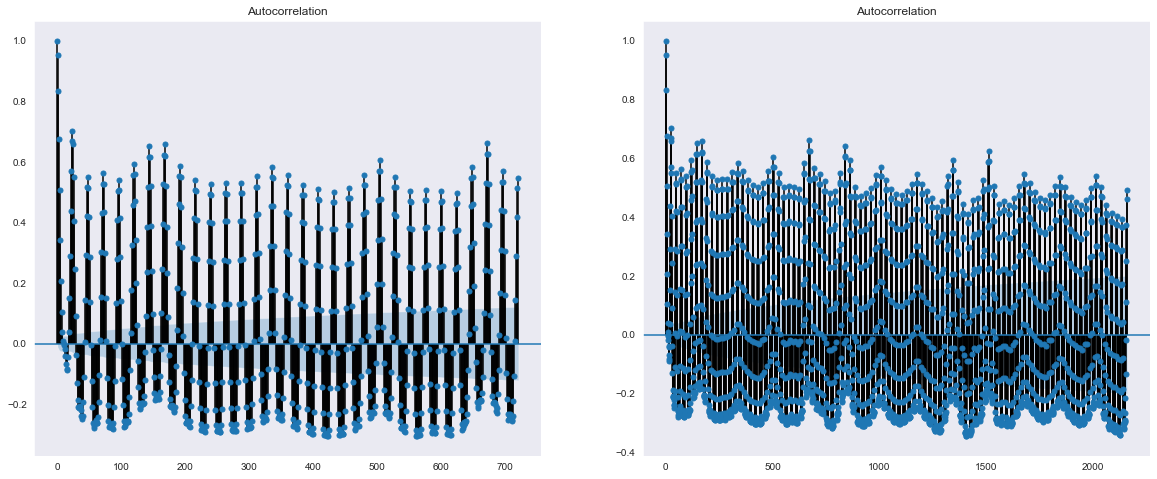

In [8]:
#isolate the original series of demand data
energy_demand_univar = df['total load actual']

fig, axs = plt.subplots(1,2, figsize=(20,8))

#we will plot the last 30 and 90 days
lags = [30*24, 90*24]

for ax, lag in zip(axs.flatten(), lags):
    plot_acf(energy_demand_univar, ax=ax, lags=lag)
plt.plot()

### Comments on Hourly Sequential (Partial) Autocorrelation Plots
In the above plots there is clear autocorrelation between consequtive hours. Nearly every (partial) autoregressive feature is significant as indicated by it's magnitude being larger than the light blue cone. This means the strong influecne between the previous hours and the current state. The difficulty is that there is such a strong correlation, that it is an indication of a low correlation to a moving average process. This means we will have a lot of noise to filter when making predictions using the data in this view. Selecting features is difficult. We see some lookbacks are stronger correlated than others, and this gives us a clue to the features that are of interest. However, we don't know if predicting each hour of the day should use the same features. 

[]

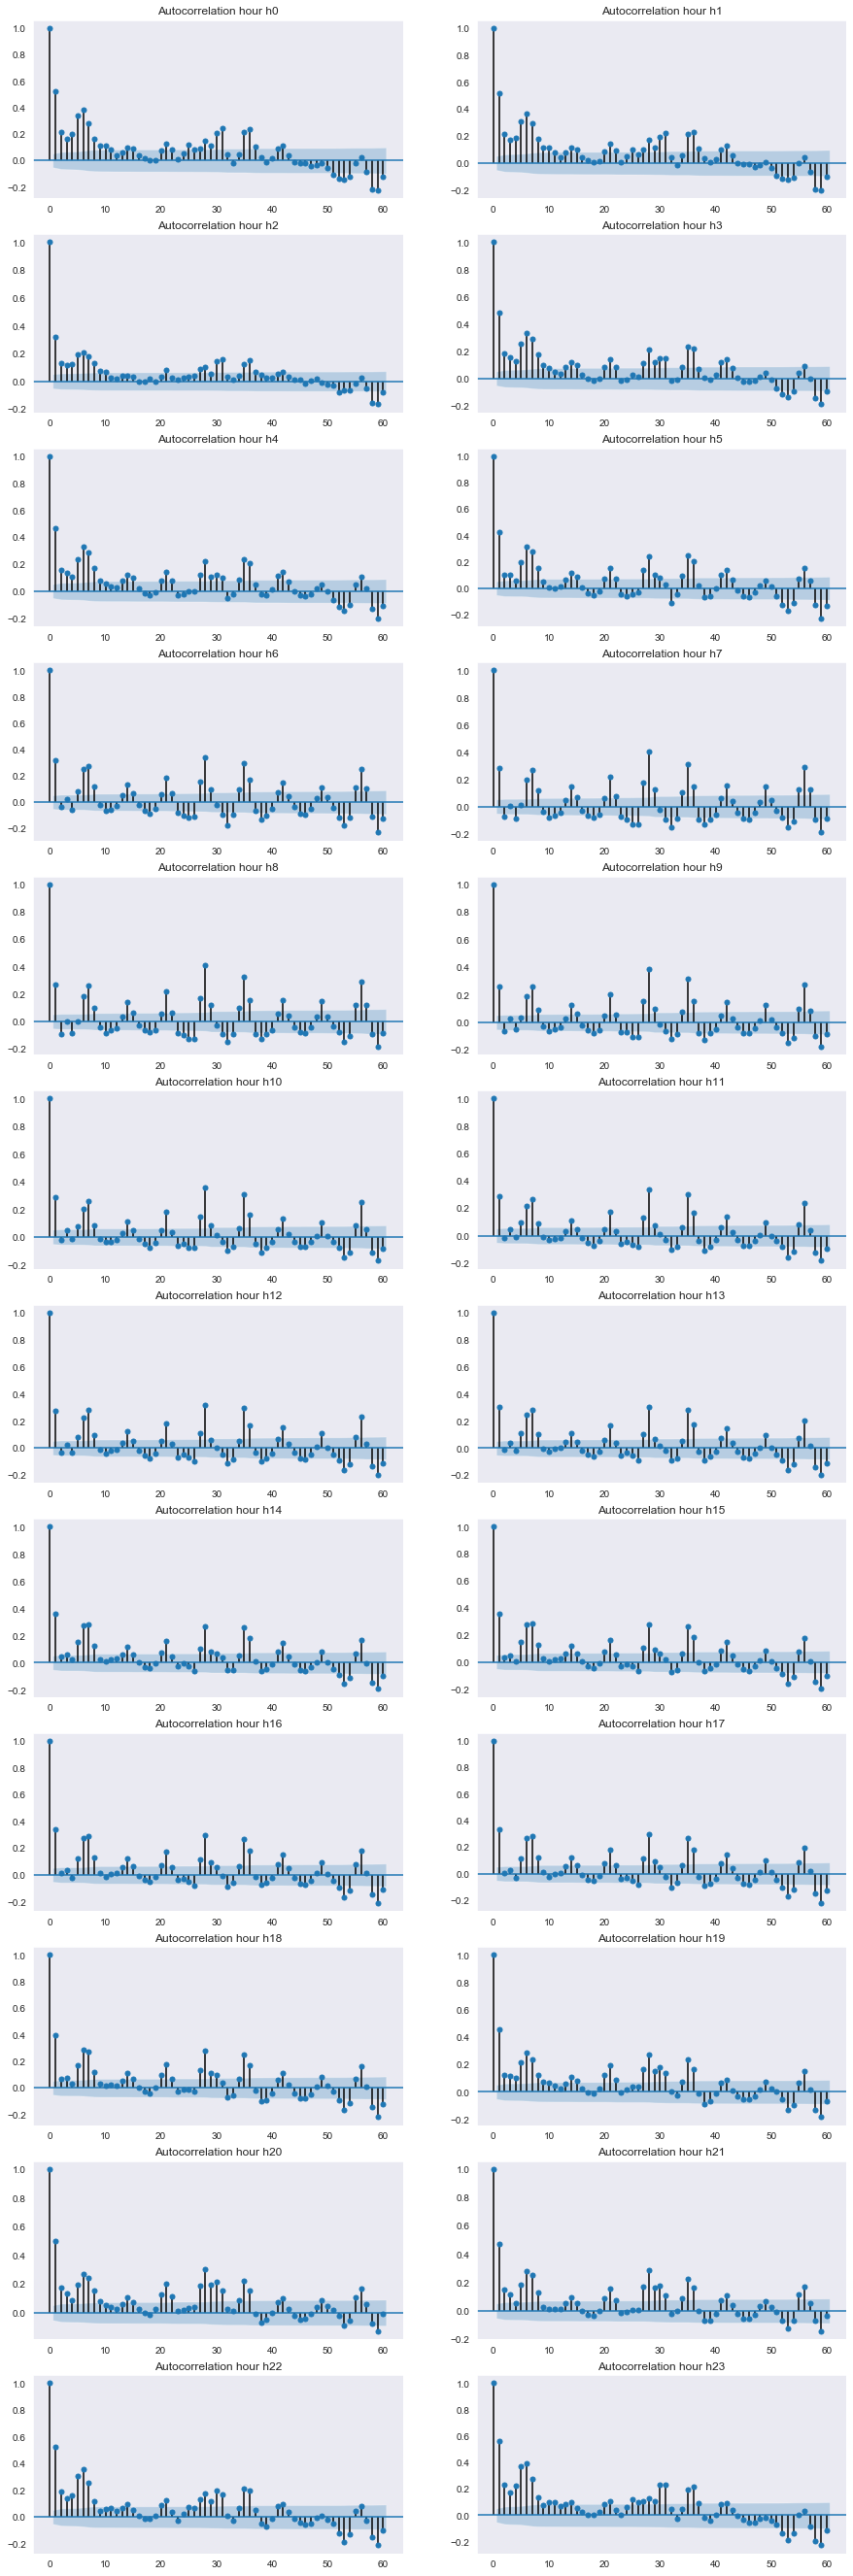

In [9]:
plots = len(day_energy.columns)
fig, axs = plt.subplots(int(plots/2), 2, figsize=(15, 2*plots))

for hour, ax in zip(day_energy.columns, axs.flatten()):
        plot_acf(day_energy.loc[:,hour], ax=ax, lags=60)
        ax.set_title('Autocorrelation hour ' + str(hour))
plt.plot()
    

[]

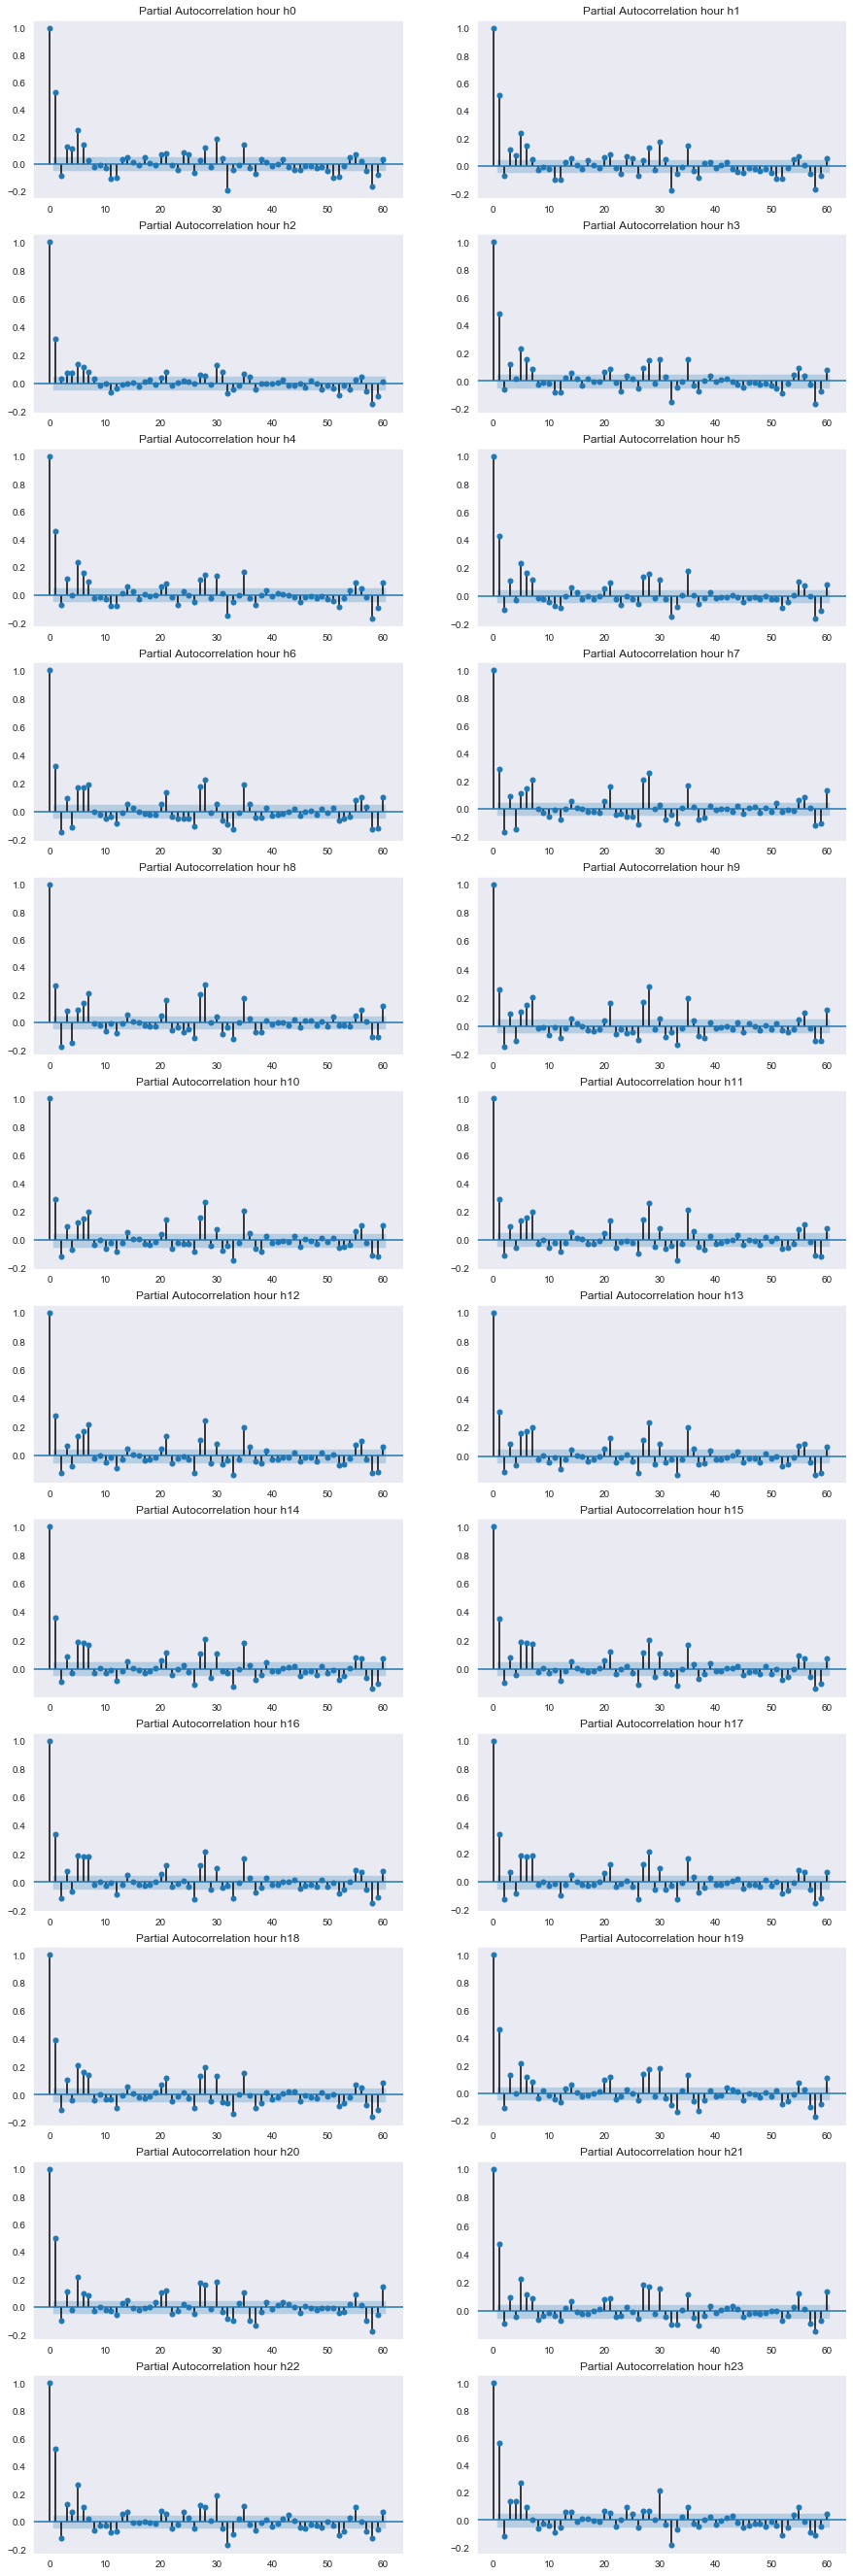

In [10]:
plots = len(day_energy.columns)
fig, axs = plt.subplots(int(plots/2), 2, figsize=(15, 2*plots))

for hour, ax in zip(day_energy.columns, axs.flatten()):
        plot_pacf(day_energy.loc[:,hour], ax=ax, lags=60)
        ax.set_title('Partial Autocorrelation hour ' + str(hour))
plt.plot()

### Comments on Hour-by-Hour transformation
Compared with the houly sequetnal plot, the hour-by-hour (partial) autocorrelation plots drop off rapidly. This indicates there is a stronger moving average process present when looking at the data in this way. 

#### Autocorrelation in the hour-by-hour plots.
- Hours 2-21 show clear cyclic autocorrelation every 7 days. The cycle of using multiples of 7 days look backs up to about 30-60 days seems like a good feature.
- Hours 0-1, and 20-23 have a diffierent structure. Here the corelation is strongest going back the first 21-30 days. The cycle of using multiples of 7 days does not seem as strong. For these hours using the last 21-30 days directly might be a better option.

#### Partial Autocorrelation
- We observe a similar correlation with the cycle of every 7ths day a strong partial autocrrelation. This time there is no clear distinction between the different hourly slices. The strongest partial autocorrelation seen through all the plots appears to be the 28th day. This 

## Building the model

#### Normalize & Create Samples (feature creation)

Normalization of the values in preparation for the LSTM model is done with MinMaxScaler

Next we setup the supervised learning problem. Following the tutorial on [MachineLearningMastery](https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/) we create paired windows of X and Y. 

X is composed of rows of multiple days (referenced as lags), and columns of the hours of the day. 
Y is then the 24 hours of observed energy demand for the target day.

The function split_sequences returns the target day as the Y and allows a combination of past days used in the prediction up to some maximum. 

In [11]:
def normalize_df(data):
    
    #normalize the dataset for working with the lstm nn
    scaler = MinMaxScaler().fit(data.values)
    data_normd = scaler.transform(data.values)
    
    #return as dataframe
    data = pd.DataFrame(data_normd, index=data.index, columns=data.columns)
    
    return data, scaler

In [12]:
#normalize the energy dataframe
day_energy_normed, scaler = normalize_df(day_energy)

In [13]:
def split_sequences(sequences, n_steps, extra_lag=False, long_lag_step=7, max_step=30, idx=0, multivar=False):
    """
    Modified based on content by Jason Brownlee from MachineLearningMastery.
    
    n_step - is the number of consecutive past steps from the target day to construct
    long_lag_step - is the size of the trailing lag beyond the n_steps. Ie. if n_steps is 3, and long_lag_step is 7 will return day -1, -2, -3, -7, -14 etc to max_step
    idx - is the starting index for the first slice
    multivari - true if the input data has multiple variable structure. false for univariate
    """
    
    #if not adding extra lag features adjust max_step and n_steps to aling
    if not extra_lag:
        max_step=n_steps
        n_steps+=1
        
    
    X, y = list(), list()
    for i in range(len(sequences)):
        
        # find the end of this pattern
        #end_ix = i + n_steps
        end_ix = i + max_step
        
        #create a list with the indexes we want to include in each sample
        slices = [x for x in range(end_ix-1,end_ix-n_steps, -1)] + [y for y in range(end_ix-n_steps, i, -long_lag_step)]
        
        #reverse the slice indexes
        slices = list(reversed(slices))
        
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break


        # gather input and output parts of the pattern
        seq_x = sequences[slices, :]
        seq_y = sequences[end_ix, :]

        X.append(seq_x)
        y.append(seq_y)
        
    X = np.array(X)
    y = np.array(y)
    
    if multivar:
        #unstack the 3rd dimension and select the first element(energy load)
        y = y[:,idx]
    
    return X, y

Following the comments in the (partial)autocorrelation analysis we will use a daily lookback of 21 days to account for the hours 0-1 and 21-23. After 21 days, we will use multiples of 7 up to a max of 60 days.

In [14]:
#create the supervised learning problem
n_steps = 21

X, Y = split_sequences(day_energy_normed.values, n_steps, extra_lag=True, long_lag_step=7, max_step=60, idx=0, multivar=False)
print(X.shape, Y.shape)
X[:5], Y[:5]

(1401, 26, 24) (1401, 24)


(array([[[0.3370004 , 0.32305783, 0.13480312, ..., 0.04953395,
          0.10132293, 0.07479675],
         [0.54047235, 0.51774077, 0.23443412, ..., 0.72989348,
          0.67874895, 0.63653754],
         [0.51826807, 0.45339816, 0.1963193 , ..., 0.88029294,
          0.85057735, 0.82046868],
         ...,
         [0.57872426, 0.56977346, 0.25475267, ..., 0.59134487,
          0.60472585, 0.63749402],
         [0.60647961, 0.55632564, 0.2303237 , ..., 0.38508655,
          0.42563279, 0.44466762],
         [0.55641906, 0.46094962, 0.17558036, ..., 0.53362184,
          0.57169075, 0.60506934]],
 
        [[0.19993944, 0.21588911, 0.1141576 , ..., 0.39194407,
          0.45285616, 0.41903396],
         [0.6361526 , 0.56718734, 0.25293101, ..., 0.79700399,
          0.75827789, 0.73582018],
         [0.73627372, 0.64218475, 0.27955533, ..., 0.95525965,
          0.93308863, 0.91142994],
         ...,
         [0.60647961, 0.55632564, 0.2303237 , ..., 0.38508655,
          0.42563279, 0.

#### Define the LSTM model

In [19]:
###define an LSTM model
#takes in parallel inputs and outputs an equal number of parallel outputs
def lstm_parallel_out(n_lags, n_hours, cells=50, learning_rate=5e-3):
    
    #define the model
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(cells, activation='relu', return_sequences=True, input_shape=(n_lags, n_hours)))
    model.add(keras.layers.LSTM(int(cells/2), activation='relu'))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(n_hours))
    
    #define the learning rate
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    
    #compile model
    model.compile(optimizer=optimizer, loss='mae')
    
    return model

#### Define a crossvalidation testbench
We are training on data from 2015 to 2018 inclusive. This is a relatively small amount of energy data. Therefore we use time series split to cross validate within the 4 year period.

In [20]:
def crossval_testbench(X, y, n_crossvals, epochs=5, verbose=0):
    
    n_hours = X.shape[-1]
    n_features = X.shape[1]
    
    tscv = TimeSeriesSplit(n_splits=n_crossvals)

    #initalize lists to capture the output
    predictions = []
    actuals = []


    #run the LSTM model on each of the time series splits
    for train, test in tscv.split(X, y):
        
        #initalize the lstm model
        lstm_base = lstm_parallel_out(n_features, n_hours, learning_rate=5e-3)
        
        #fit the model
        lstm_base.fit(X[train], y[train], epochs=epochs, verbose=verbose, shuffle=False)
        
        #make predictions
        predict = lstm_base.predict(X[test], verbose=verbose)


        #inverse transform the predictions and actual values
        prediction = scaler.inverse_transform(predict)
        actual = scaler.inverse_transform(y[test].copy())

        #save the results in a list
        predictions.append(prediction)
        actuals.append(actual)
        
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    
    return predictions, actuals

In [21]:
preds, actuals = crossval_testbench(X, Y, 2, epochs=150, verbose=1)

/Users/sopank/miniconda3/envs/water_demand/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/150
15/15 [==============================] - 2s 13ms/step - loss: 0.3505
Epoch 2/150
15/15 [==============================] - 0s 11ms/step - loss: 0.2154
Epoch 3/150
15/15 [==============================] - 0s 12ms/step - loss: 0.1866
Epoch 4/150
15/15 [==============================] - 0s 12ms/step - loss: 0.1712
Epoch 5/150
15/15 [==============================] - 0s 11ms/step - loss: 0.1657
Epoch 6/150
15/15 [==============================] - 0s 12ms/step - loss: 0.1647
Epoch 7/150
15/15 [==============================] - 0s 12ms/step - loss: 0.1603
Epoch 8/150
15/15 [==============================] - 0s 11ms/step - loss: 0.1566
Epoch 9/150
15/15 [==============================] - 0s 11ms/step - loss: 0.1548
Epoch 10/150
15/15 [==============================] - 0s 11ms/step - loss: 0.1531
Epoch 11/150
15/15 [==============================] - 0s 11ms/step - loss: 0.1475
Epoch 12/150
15/15 [==============================] - 0s 12ms/step - loss: 0.1504
Epoch 13/150
15/15 [=====

15/15 [==============================] - 0s 13ms/step - loss: 0.1288
Epoch 102/150
15/15 [==============================] - 0s 13ms/step - loss: 0.1276
Epoch 103/150
15/15 [==============================] - 0s 12ms/step - loss: 0.1242
Epoch 104/150
15/15 [==============================] - 0s 11ms/step - loss: 0.1222
Epoch 105/150
15/15 [==============================] - 0s 11ms/step - loss: 0.1195
Epoch 106/150
15/15 [==============================] - 0s 11ms/step - loss: 0.1201
Epoch 107/150
15/15 [==============================] - 0s 13ms/step - loss: 0.1218
Epoch 108/150
15/15 [==============================] - 0s 14ms/step - loss: 0.1196
Epoch 109/150
15/15 [==============================] - 0s 13ms/step - loss: 0.1204
Epoch 110/150
15/15 [==============================] - 0s 12ms/step - loss: 0.1207
Epoch 111/150
15/15 [==============================] - 0s 12ms/step - loss: 0.1176
Epoch 112/150
15/15 [==============================] - 0s 11ms/step - loss: 0.1174
Epoch 113/150
15/1

/Users/sopank/miniconda3/envs/water_demand/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


30/30 [==============================] - 2s 16ms/step - loss: 0.2529
Epoch 2/150
30/30 [==============================] - 0s 15ms/step - loss: 0.1771
Epoch 3/150
30/30 [==============================] - 0s 14ms/step - loss: 0.1654
Epoch 4/150
30/30 [==============================] - 0s 13ms/step - loss: 0.1602
Epoch 5/150
30/30 [==============================] - 0s 12ms/step - loss: 0.1540
Epoch 6/150
30/30 [==============================] - 0s 12ms/step - loss: 0.1527
Epoch 7/150
30/30 [==============================] - 0s 14ms/step - loss: 0.1502
Epoch 8/150
30/30 [==============================] - 0s 13ms/step - loss: 0.1482
Epoch 9/150
30/30 [==============================] - 0s 12ms/step - loss: 0.1461
Epoch 10/150
30/30 [==============================] - 0s 12ms/step - loss: 0.1465
Epoch 11/150
30/30 [==============================] - 0s 13ms/step - loss: 0.1439
Epoch 12/150
30/30 [==============================] - 0s 14ms/step - loss: 0.1405
Epoch 13/150
30/30 [=================

30/30 [==============================] - 0s 11ms/step - loss: 0.1099
Epoch 102/150
30/30 [==============================] - 0s 11ms/step - loss: 0.1102
Epoch 103/150
30/30 [==============================] - 0s 11ms/step - loss: 0.1083
Epoch 104/150
30/30 [==============================] - 0s 11ms/step - loss: 0.1105
Epoch 105/150
30/30 [==============================] - 0s 11ms/step - loss: 0.1075
Epoch 106/150
30/30 [==============================] - 0s 10ms/step - loss: 0.1083
Epoch 107/150
30/30 [==============================] - 0s 11ms/step - loss: 0.1070
Epoch 108/150
30/30 [==============================] - 0s 10ms/step - loss: 0.1092
Epoch 109/150
30/30 [==============================] - 0s 11ms/step - loss: 0.1097
Epoch 110/150
30/30 [==============================] - 0s 10ms/step - loss: 0.1078
Epoch 111/150
30/30 [==============================] - 0s 11ms/step - loss: 0.1076
Epoch 112/150
30/30 [==============================] - 0s 10ms/step - loss: 0.1083
Epoch 113/150
30/3

In [22]:
preds.shape, actuals.shape

((2, 467, 24), (2, 467, 24))

## Investigating Model Performance

We calcualte and plot MAE for each hour predicted. This gives an idea of where the model is predicting well, and where it is making errors.

To compare model runs we can calcualte total model MAE. However to do this we must sum all errors for each hour, with all other errors and then take the mean.


In [23]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [24]:
#MAPE for a specific hour
error_h0 = mean_absolute_percentage_error(actuals[0,:5,0], preds[0, :5,0])
print(f'MAPE for Hour 0: {round(error_h0, 2)}')

MAPE for Hour 0: 3.36


In [25]:
crossvals = actuals.shape[0]
hours = actuals.shape[2]

errors_crossvals = list()
for crossval in range(crossvals):
    errors_hourly = [mean_absolute_percentage_error(actuals[crossval, :, hour], preds[crossval, :, hour]) for hour in range(hours)]
    errors_crossvals.append(errors_hourly)
    
errors = pd.DataFrame(errors_crossvals)
errors['mean'] = errors.mean(axis=1)
errors.index.name='crossval set'
errors.columns.name='hours'
errors

hours,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,mean
crossval set,,,,,,,,,,,,,,,,,,,,,,,,,
0,4.756025,4.871494,5.064424,5.003374,5.090942,5.286796,6.556975,9.341180,10.405842,9.321111,8.142740,7.681357,7.637630,7.667709,7.475804,8.055897,8.559827,8.738693,8.484626,8.151140,7.319778,5.753225,5.154121,4.841266,7.056749
1,3.920028,3.679486,3.908484,3.736168,3.827342,4.074911,5.924424,9.120597,9.880098,8.397718,7.086574,6.425946,6.448546,6.220502,5.893114,6.592462,7.184659,7.254405,7.048551,6.869892,6.558402,5.232193,4.782106,4.427584,6.020591


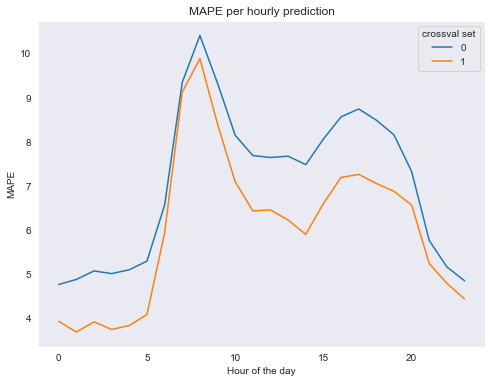

In [26]:
plt.figure(figsize=(8,6))
plt.plot(errors.drop(columns='mean').T)
plt.title('MAPE per hourly prediction')
plt.legend(errors.index, title='crossval set')
plt.xlabel('Hour of the day')
plt.ylabel('MAPE')
plt.show()

## Predicting on an Unseen Test Set

The test bench allowed to modify and iterate on the model. To get an evaluation on model performance with unknown data we create a typical train test split.

To do this we will also need to run the train and test sets through the preprocessing pipeline again.[](http://)

In [27]:
def train_test_split(df, split_date):
    
    
    train_date = pd.Timestamp(split_date).strftime('%Y-%m-%d')
    test_date = (pd.Timestamp(split_date) + timedelta(1)).strftime('%Y-%m-%d')
    
    df_train = df[:train_date]
    df_test = df[test_date:]
    
    return df_train, df_test

train, test = train_test_split(day_energy, '2017-12-31')

print(f'Training start date {train.index.min()} end date {train.index.max()}')
print(f'Training start date {test.index.min()} end date {test.index.max()}')

Training start date 2015-01-01 00:00:00 end date 2017-12-31 00:00:00
Training start date 2018-01-01 00:00:00 end date 2018-12-31 00:00:00


In [28]:
train_norm, scalar = normalize_df(train)
test_norm = scalar.transform(test)

#create the supervised learning problem
n_steps = 21

X_train, Y_train = split_sequences(train_norm.values, n_steps, extra_lag=True, long_lag_step=7, max_step=60, idx=0, multivar=False)

print(f'Training Set X {X_train.shape} and Y {Y_train.shape}')

Training Set X (1036, 26, 24) and Y (1036, 24)


/Users/sopank/miniconda3/envs/water_demand/lib/python3.9/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


To construct the testing set samples we must add the last 60 (corresponding to max_step) values to the train. These will be used to make the first prediction in the test set.

In [29]:
test_set = np.vstack([train_norm.values[-60:], test_norm])
print(f'Dimensions of the test set with training data needed for predictions: {test_set.shape}')

X_test, Y_test = split_sequences(test_set, n_steps, extra_lag=True, long_lag_step=7, max_step=60, idx=0, multivar=False)

print(f'Testing Set X {X_test.shape} and Y {Y_test.shape}')

Dimensions of the test set with training data needed for predictions: (425, 24)
Testing Set X (365, 26, 24) and Y (365, 24)


### Train model
Use the entire training set for the model to learn.

In [30]:
n_features=X_train.shape[1]
n_hours=X_train.shape[2]
#initalize the lstm model
lstm_eval = lstm_parallel_out(n_features, n_hours, learning_rate=5e-3)
        
#fit the model
lstm_eval.fit(X_train, Y_train, epochs=350, verbose=1, shuffle=False)
        
#check predictions on the train set
train_predictions = lstm_eval.predict(X_train, verbose=1)

#run predictions on test data
test_predictions = lstm_eval.predict(X_test, verbose=1)

/Users/sopank/miniconda3/envs/water_demand/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/350
33/33 [==============================] - 2s 13ms/step - loss: 0.2897
Epoch 2/350
33/33 [==============================] - 0s 14ms/step - loss: 0.1757
Epoch 3/350
33/33 [==============================] - 0s 12ms/step - loss: 0.1640
Epoch 4/350
33/33 [==============================] - 0s 12ms/step - loss: 0.1587
Epoch 5/350
33/33 [==============================] - 0s 13ms/step - loss: 0.1540
Epoch 6/350
33/33 [==============================] - 0s 13ms/step - loss: 0.1508
Epoch 7/350
33/33 [==============================] - 0s 15ms/step - loss: 0.1499
Epoch 8/350
33/33 [==============================] - 0s 15ms/step - loss: 0.1486
Epoch 9/350
33/33 [==============================] - 1s 16ms/step - loss: 0.1474
Epoch 10/350
33/33 [==============================] - 0s 14ms/step - loss: 0.1452
Epoch 11/350
33/33 [==============================] - 0s 15ms/step - loss: 0.1439
Epoch 12/350
33/33 [==============================] - 1s 16ms/step - loss: 0.1433
Epoch 13/350
33/33 [=====

33/33 [==============================] - 0s 15ms/step - loss: 0.1076
Epoch 101/350
33/33 [==============================] - 0s 14ms/step - loss: 0.1073
Epoch 102/350
33/33 [==============================] - 0s 13ms/step - loss: 0.1062
Epoch 103/350
33/33 [==============================] - 1s 16ms/step - loss: 0.1053
Epoch 104/350
33/33 [==============================] - 0s 14ms/step - loss: 0.1032
Epoch 105/350
33/33 [==============================] - 1s 15ms/step - loss: 0.1042
Epoch 106/350
33/33 [==============================] - 0s 14ms/step - loss: 0.1016
Epoch 107/350
33/33 [==============================] - 1s 15ms/step - loss: 0.1051
Epoch 108/350
33/33 [==============================] - 0s 15ms/step - loss: 0.1058
Epoch 109/350
33/33 [==============================] - 1s 25ms/step - loss: 0.1043
Epoch 110/350
33/33 [==============================] - 1s 31ms/step - loss: 0.1042
Epoch 111/350
33/33 [==============================] - 1s 19ms/step - loss: 0.1039
Epoch 112/350
33/3

33/33 [==============================] - 0s 13ms/step - loss: 0.0936
Epoch 199/350
33/33 [==============================] - 0s 12ms/step - loss: 0.0927
Epoch 200/350
33/33 [==============================] - 0s 12ms/step - loss: 0.0949
Epoch 201/350
33/33 [==============================] - 0s 12ms/step - loss: 0.0971
Epoch 202/350
33/33 [==============================] - 0s 12ms/step - loss: 0.0944
Epoch 203/350
33/33 [==============================] - 0s 13ms/step - loss: 0.0959
Epoch 204/350
33/33 [==============================] - 0s 12ms/step - loss: 0.0927
Epoch 205/350
33/33 [==============================] - 0s 13ms/step - loss: 0.0958
Epoch 206/350
33/33 [==============================] - 0s 12ms/step - loss: 0.0933
Epoch 207/350
33/33 [==============================] - 0s 12ms/step - loss: 0.0940
Epoch 208/350
33/33 [==============================] - 0s 11ms/step - loss: 0.0972
Epoch 209/350
33/33 [==============================] - 0s 12ms/step - loss: 0.0978
Epoch 210/350
33/3

33/33 [==============================] - 0s 12ms/step - loss: 0.0828
Epoch 297/350
33/33 [==============================] - 0s 12ms/step - loss: 0.0815
Epoch 298/350
33/33 [==============================] - 0s 12ms/step - loss: 0.0853
Epoch 299/350
33/33 [==============================] - 0s 12ms/step - loss: 0.0850
Epoch 300/350
33/33 [==============================] - 0s 12ms/step - loss: 0.0872
Epoch 301/350
33/33 [==============================] - 0s 12ms/step - loss: 0.0854
Epoch 302/350
33/33 [==============================] - 0s 12ms/step - loss: 0.0813
Epoch 303/350
33/33 [==============================] - 0s 12ms/step - loss: 0.0841
Epoch 304/350
33/33 [==============================] - 0s 13ms/step - loss: 0.0818
Epoch 305/350
33/33 [==============================] - 0s 14ms/step - loss: 0.0811
Epoch 306/350
33/33 [==============================] - 0s 13ms/step - loss: 0.0816
Epoch 307/350
33/33 [==============================] - 0s 13ms/step - loss: 0.0830
Epoch 308/350
33/3

### Rescale Predictions and Evaluate

In [31]:
train_preds = scalar.inverse_transform(train_predictions)
test_preds = scalar.inverse_transform(test_predictions)
Y_train = scalar.inverse_transform(Y_train)
Y_test = scalar.inverse_transform(Y_test)

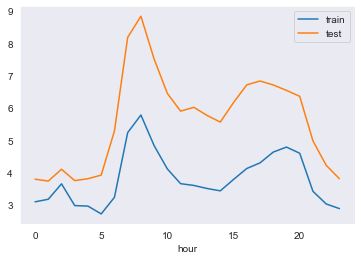

In [32]:
train_error = pd.DataFrame([mean_absolute_percentage_error(Y_train[:, hour], train_preds[:, hour]) for hour in range(hours)], columns=['train'])
test_error = pd.DataFrame([mean_absolute_percentage_error(Y_test[:, hour], test_preds[:, hour]) for hour in range(hours)], columns=['test'])

errors = pd.concat([train_error, test_error], axis=1)
errors.index.name = 'hour'
errors.plot()

### Plot Holdout Test Predictions

/var/folders/rq/t0jx4phj28b6dqnxxrhlps440000gp/T/ipykernel_38874/2478879957.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig.add_subplot()
/Users/sopank/miniconda3/envs/water_demand/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


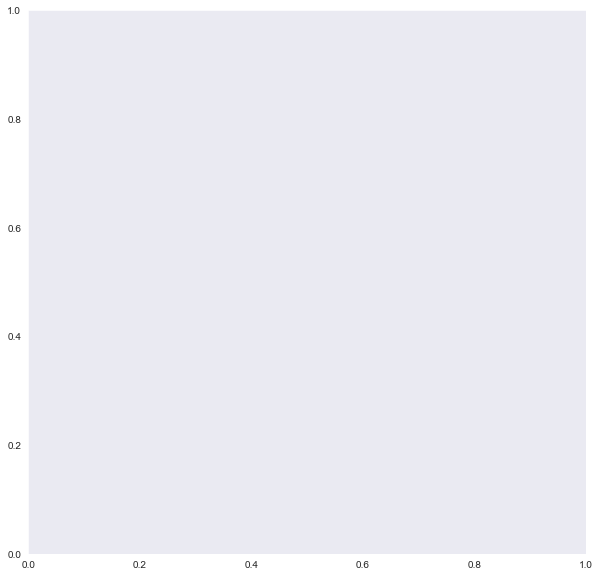

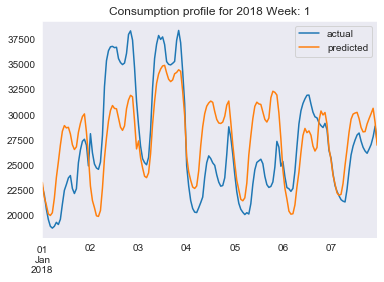

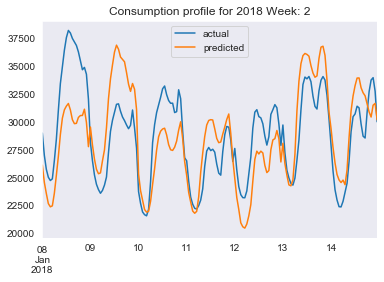

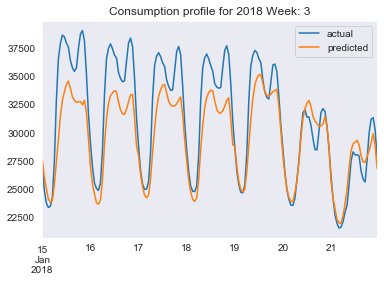

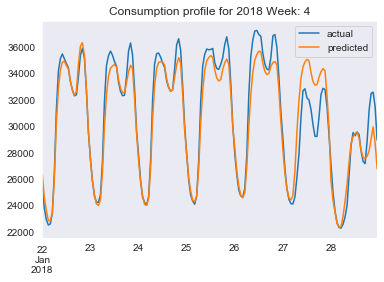

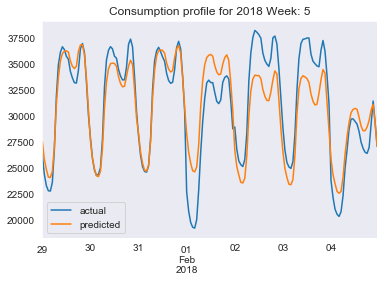

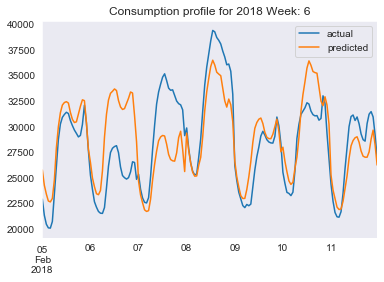

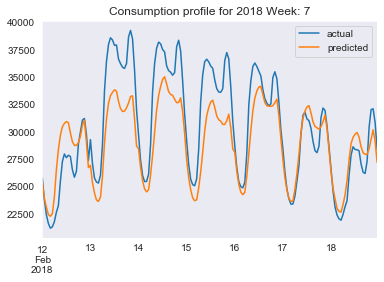

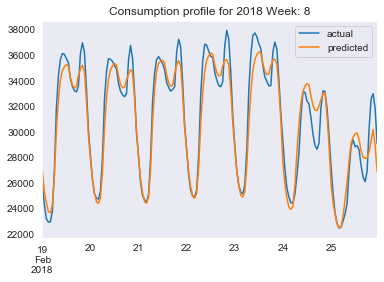

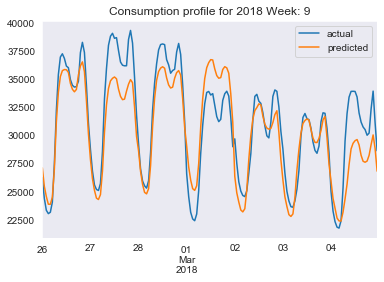

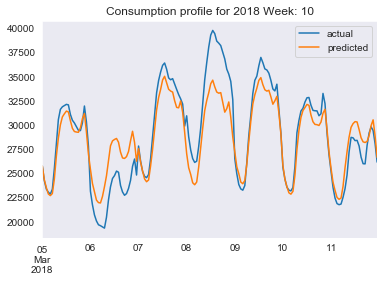

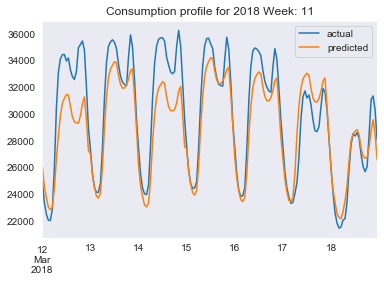

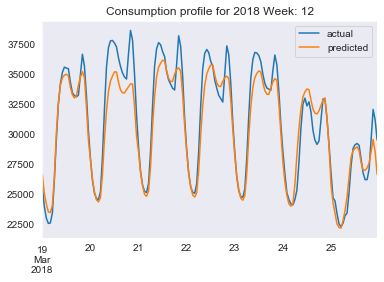

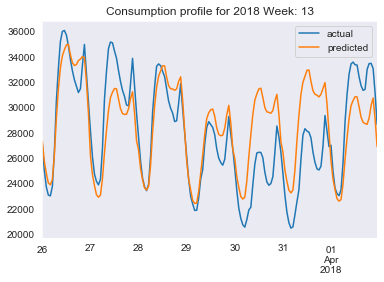

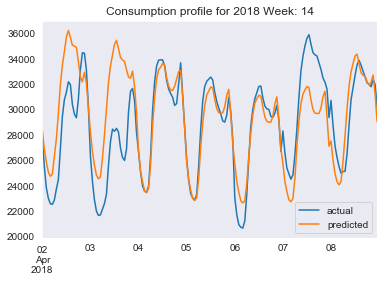

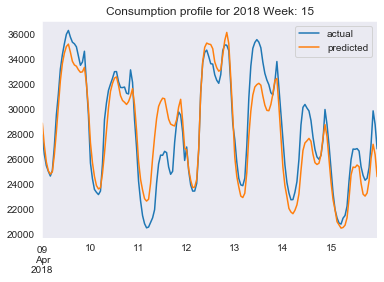

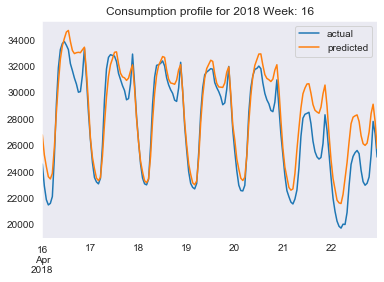

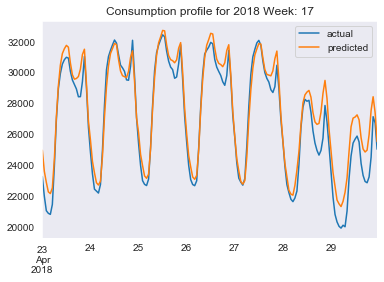

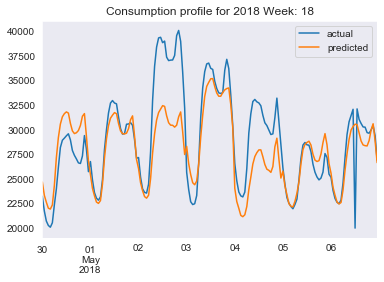

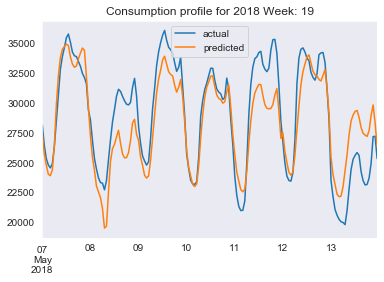

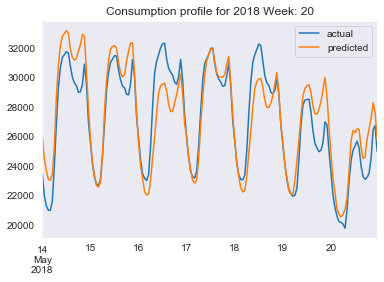

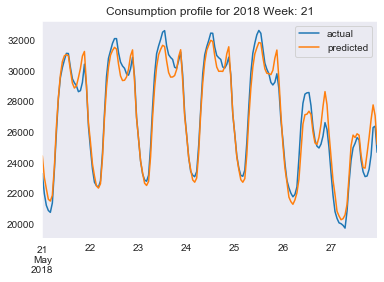

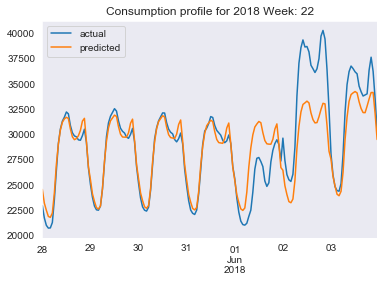

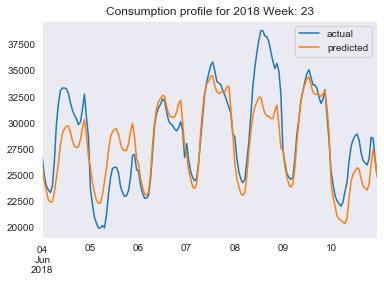

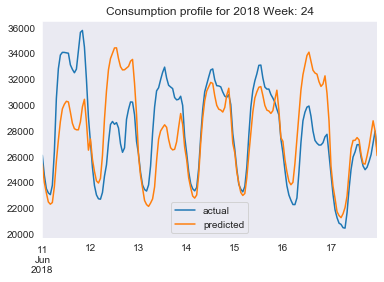

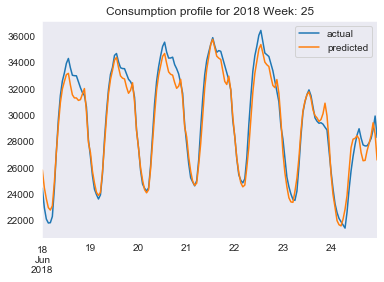

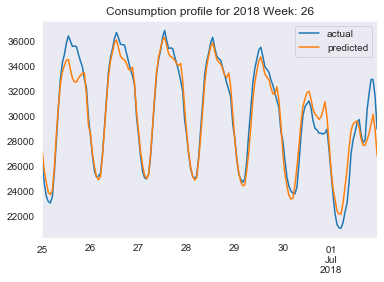

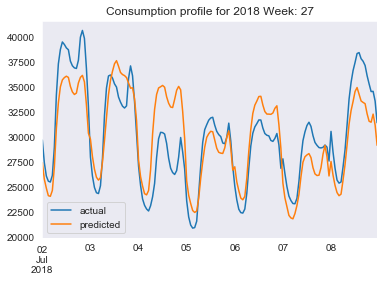

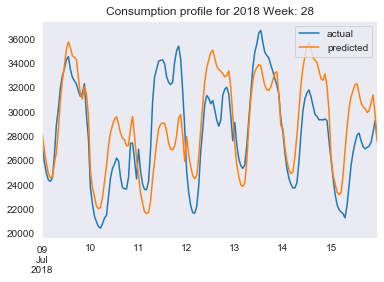

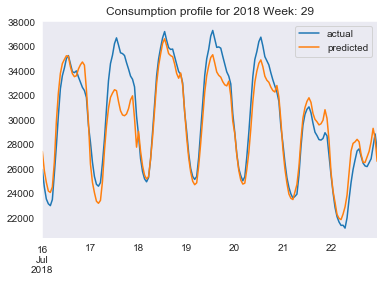

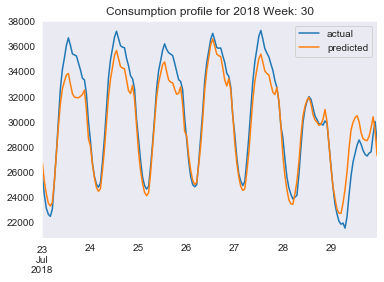

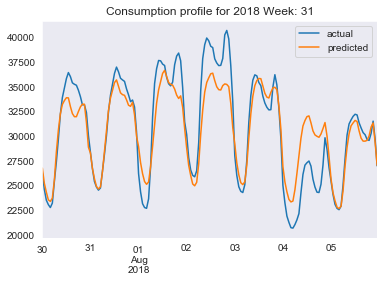

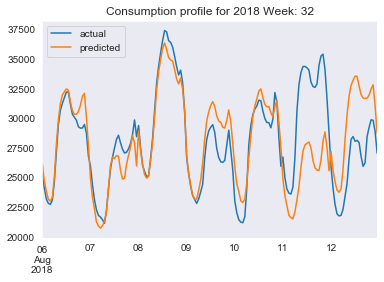

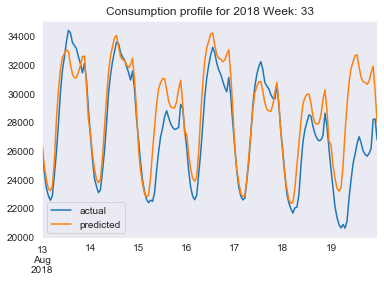

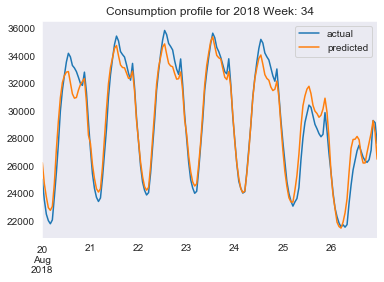

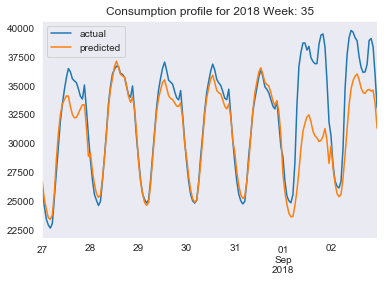

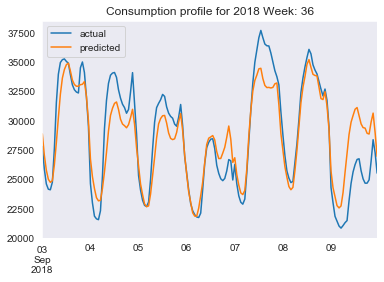

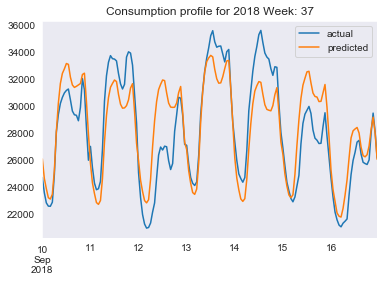

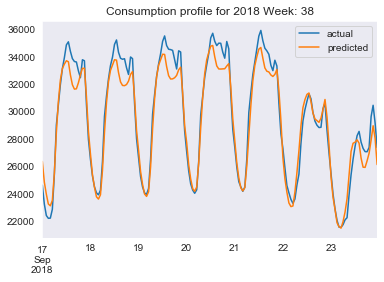

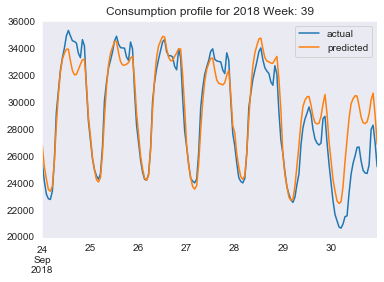

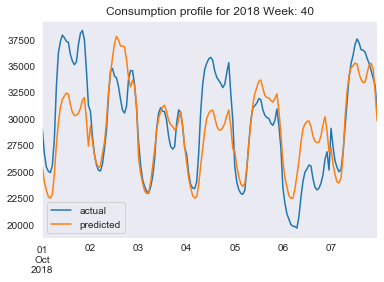

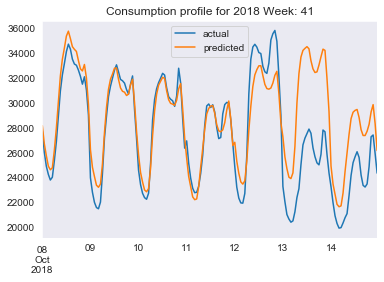

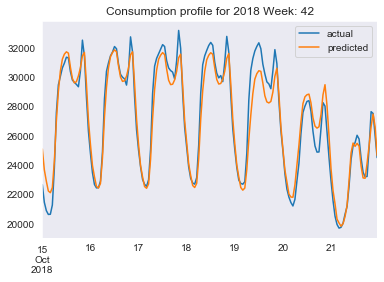

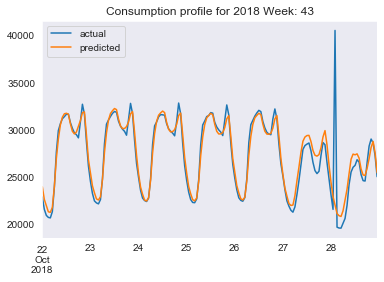

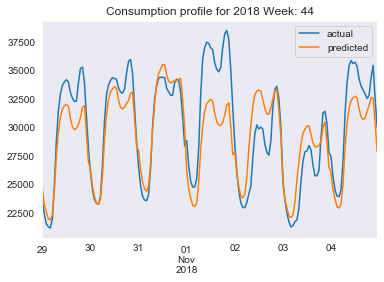

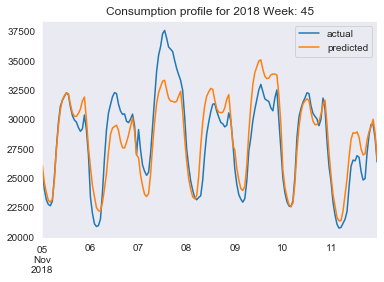

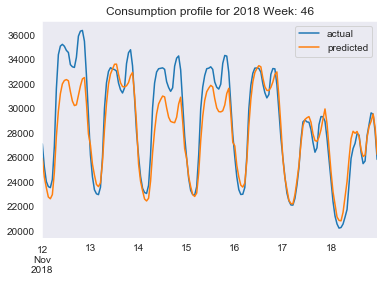

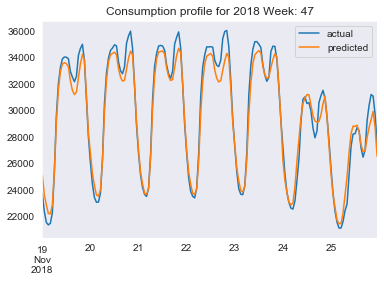

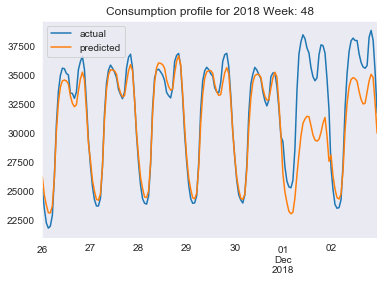

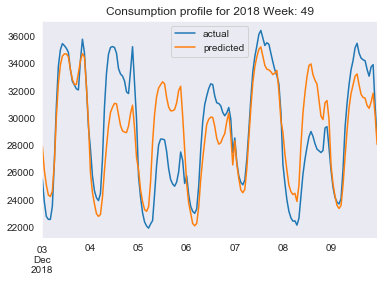

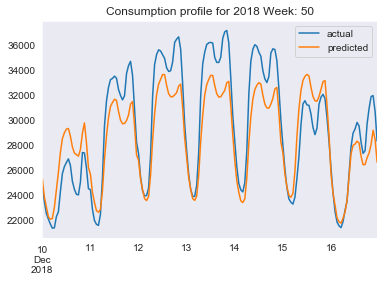

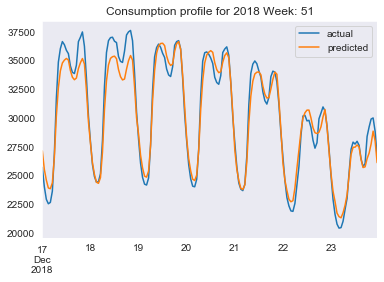

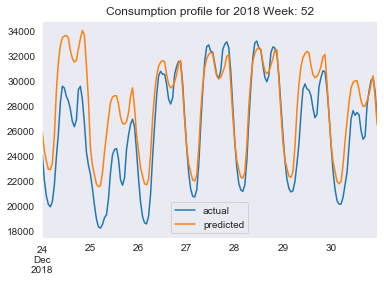

In [33]:
test_df = pd.DataFrame(test_preds).stack()
Y_test_df = pd.DataFrame(Y_test).stack()

preds_df = pd.concat([Y_test_df, test_df], axis=1)
preds_df.columns = ['actual', 'predicted']

preds_df.index = pd.DatetimeIndex(pd.date_range(start='2018-01-01T0000', end='2018-12-31T2300', freq='H'))

fig = plt.figure(figsize=(10,10))

for week in range(52):

    fig.add_subplot()
    preds_df.iloc[week*7*24:(week+1)*7* 24].plot()
    plt.title(f'Consumption profile for 2018 Week: {week+1}')

## Analysis and Next Steps: How could this model be improved
The model performs reasonably well on hours 12 to 23 and poorly on select hours early in the day. Considering the making predictions on a test set the model preforms almost equally well and shows limited overfitting. One thing to notice in the weekly plots is that some weeks the model performs very well. Other weeks not well at all. This indicates that processes outside the scope of the univaraite lag features is not being captured.


To improve the model we can consider several courses of action.
1. Add more energy consumption data either to the dataset directly, or in the form of adjusting the lag times. We saw that for some hours (21-23) there was a strong autocorrelation with the most recent days while with other hours (0-21) it was a longer lag period of about each 7 days that showed the stronger autocorrelation. In this workbook we have left the LSTM model to figure out the difference between the hours. We could feed the model different configurations of lags for the different hours of the day to improve model performance in specfic hours.
2. Add more features. The dataset contains other relevant features that may be used to forecast the coming 24 hours of demand. Several that might be of interests are:
    - Weather features in major cities. Major cities consume the majority of power. We can investigate the correlation between weather and energy demand and use it as a correlated input in the model.
    - Energy consumption in shared power regions. In this case we ware working with energy demand from Spain. Spain engages in transborder interactions with portugal and france. There is possibly a correlation between power transfers that would help the model forecast better.
    - Encode a day of the week and holidays feature. The model is already considering day of the week implicitly by looking at the 7th, 14th, 21st etc lags. So its unlikely day of the week encoding will improve the perforamnce. Holidays however are not consdiered and would add new information to the model. The challenge here is that for each holiday the model will only have 4 data points (corresponding to the 4 years of data). This is limited data for the model to learn from.
    - Model strcuture and hyperparameters. In 1 we identify how using different lag structures on a per hour basis. We could test the model structure with different architectures that support this. One example might be to use a sequence to sequence model architecture. Another option is to train on more epochs and see the relationship between more training and performance.
3. Apply regularization techniques such as dropout to account for any overfitting.
4. Use the remaining data from 2019 as a test set and evaluate the model on unseen data.
    
    
If you have found this model interesting please upvote! And if you have any ideas or comments on this work please share, would love to hear what you think!